In [1]:
import re
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Dense,Flatten,Embedding,Dropout,GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import spacy
import nltk
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#!python -m spacy download en_core_web_lg

In [4]:
df = pd.read_csv('Datasets/hate_speech_neutral.csv',index_col = 0 )
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<h3> Class :    0 is Hate     |      1 is Offensive    |  2 is neutral   </h3>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [6]:
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [7]:
# Since hate class is very less we need to balance these classes

In [8]:
df[df['class'] == 0].sample(1430)

,count,hate_speech,offensive_language,neither,class,tweet
3204,3,2,1,0,0,@EnglishBrit123 sounds like a good idea. But I...
24338,3,2,1,0,0,fucking CHRIST i hate tutors and TAs. you lite...
23357,3,2,1,0,0,Why does this faggot in front of me have to ge...
9647,3,2,1,0,0,Gay ass nigga &#128514;&#128514; bitch you tho...
16697,3,2,1,0,0,RT @MANIAC3X: @larryx2010 @FloydMayweather not...
...,...,...,...,...,...,...
3777,3,3,0,0,0,@JoeDouglas1 sit down and stfu raghead @Darkni...
18670,3,2,1,0,0,RT @_ChickenGeorge: DEAD!!&#128128;&#8220;@TAk...
2827,3,3,0,0,0,@Campos_uli is a fag #hesgay
16377,3,2,1,0,0,RT @Kidd_BravO615: Nigga wanna bitch about a p...


In [9]:
balanced_df = pd.DataFrame()

# taking min for balancing
min_class = min(df['class'].value_counts().values)

for i in df['class'].unique():
    temp = df[df['class'] == i].sample(min_class)
    balanced_df = balanced_df.append(temp,ignore_index=True)

balanced_df.shape

(4290, 6)

In [10]:
1430*3

4290

In [11]:
balanced_df['class'].value_counts()

2    1430
1    1430
0    1430
Name: class, dtype: int64

# Data Preprocessing

In [12]:
# Removing Retweets 
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub('RT','',x))

In [13]:
# Lower Casing the characters
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : str(x).lower())

In [14]:
# Removing Emails
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b','',x))

In [15]:
# Removing multiple spaces
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub(r'[\s+]',' ',x)) 

In [16]:
# Removing consecutive occurances of characters 
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub("(.)\\1{2,}", "\\1", x))

In [17]:
# Removing mentions 
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub(r'@\w+','',x)) 

In [18]:
# Removing html tags 
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub(r'<.*?>','',x)) 

In [19]:
# Removing html tags 
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub(r'http.*','',x)) 

In [20]:
# Removing Special Characters
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]','',x))
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub('[\n]','',x))

In [21]:
# Removing Digits
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub('\s+\d+\s+',' ',x))
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x : re.sub('\s+\d+$',' ',x))

# Text Tokenization


In [22]:
text = balanced_df['tweet'].to_list()

In [23]:
text

['  joey badass said traded in my nikes for a new mic i guess its safe to say he sold his soles for a new life',
 '  shouldve lost in carolina in houston amp tonight in st louis lucky  seahawks are complete trash',
 ' ps3 and case is still in the trash can idgaf anymore',
 'so my light was off amp door was closed  mom walks in turn lights on  tells me to take trash out in the morning  then walked out light on',
 '  i am one proud hillbilly',
 'youre like a lucky leprechaun with a charmed day on your hand more for gemini ',
 ' i wonder if i have my very own nsa spook following me by now',
 '  in dc fri bengali harlem readingconvo  14th st    ',
 '  breaking louisville coach charlie strong is expected to accept texas job according to espn amp media reports ',
 'im just tryna get to sleep before the birds start getting rowdy',
 '  for lots of great oldies check out memories and more with yankee rose today from pm to pm eastern ',
 '  charlie crist refuses to back down from racebased attac

In [24]:
# Creating Tokenizer object that assigns a unique integer to a word
# Creates a dictionary of words that occur in a text
token = Tokenizer()
token.fit_on_texts(text)

In [25]:
# Display Token Word
token.index_word

{1: 'a',
 2: 'the',
 3: 'i',
 4: 'you',
 5: 'to',
 6: 'bitch',
 7: 'and',
 8: 'is',
 9: 'in',
 10: 'my',
 11: 'that',
 12: 'of',
 13: 'like',
 14: 'on',
 15: 'me',
 16: 'be',
 17: 'for',
 18: 'trash',
 19: 'this',
 20: 'it',
 21: 'im',
 22: 'with',
 23: 'are',
 24: 'your',
 25: 'dont',
 26: 'they',
 27: 'bitches',
 28: 'if',
 29: 'just',
 30: 'so',
 31: 'all',
 32: 'ass',
 33: 'up',
 34: 'nigga',
 35: 'hoes',
 36: 'but',
 37: 'hoe',
 38: 'u',
 39: 'no',
 40: 'get',
 41: 'faggot',
 42: 'fuck',
 43: 'was',
 44: 'at',
 45: 'not',
 46: 'have',
 47: 'pussy',
 48: 'got',
 49: 'he',
 50: 'when',
 51: 'amp',
 52: 'its',
 53: 'out',
 54: 'these',
 55: 'lol',
 56: 'white',
 57: 'shit',
 58: 'or',
 59: 'what',
 60: 'can',
 61: 'some',
 62: 'we',
 63: 'aint',
 64: 'fucking',
 65: 'do',
 66: '8220',
 67: 'she',
 68: 'niggas',
 69: 'youre',
 70: 'about',
 71: 'who',
 72: 'one',
 73: 'her',
 74: 'them',
 75: 'nigger',
 76: 'how',
 77: 'as',
 78: 'go',
 79: 'know',
 80: 'cant',
 81: 'from',
 82: 'his'

In [26]:
# Count of words
token.word_counts

OrderedDict([('joey', 2),
             ('badass', 1),
             ('said', 55),
             ('traded', 2),
             ('in', 584),
             ('my', 533),
             ('nikes', 2),
             ('for', 377),
             ('a', 1592),
             ('new', 58),
             ('mic', 2),
             ('i', 1177),
             ('guess', 18),
             ('its', 165),
             ('safe', 7),
             ('to', 948),
             ('say', 88),
             ('he', 173),
             ('sold', 4),
             ('his', 105),
             ('soles', 9),
             ('life', 44),
             ('shouldve', 3),
             ('lost', 13),
             ('carolina', 1),
             ('houston', 6),
             ('amp', 168),
             ('tonight', 12),
             ('st', 5),
             ('louis', 1),
             ('lucky', 3),
             ('seahawks', 1),
             ('are', 276),
             ('complete', 3),
             ('trash', 367),
             ('ps3', 1),
             ('and', 694

In [27]:
# Assigns a specific integer to a word
token.texts_to_sequences('I Love you')

[[3], [], [1735], [964], [], [8157], [], [783], [964], [38]]

In [28]:
# Assigning a specific integer to a word using texts_to_sequences
vocab_size =  len(token.word_counts) + 1
encoded_text = token.texts_to_sequences(text)

In [29]:
print('Vocab Size = ',vocab_size,'\n'*2,encoded_text)

Vocab Size =  8667 

 [[2122, 3342, 144, 2123, 9, 10, 2124, 17, 1, 136, 2125, 3, 385, 52, 801, 5, 96, 49, 1262, 82, 634, 17, 1, 136, 173], [1554, 488, 9, 3343, 9, 903, 51, 514, 9, 1047, 3344, 1555, 3345, 23, 1556, 18], [3346, 7, 1048, 8, 98, 9, 2, 18, 60, 1557, 802], [30, 10, 386, 43, 91, 51, 702, 43, 1263, 313, 2126, 9, 273, 803, 14, 1558, 15, 5, 152, 18, 53, 9, 2, 418, 95, 1049, 53, 386, 14], [3, 174, 72, 515, 635], [69, 13, 1, 1555, 2127, 22, 1, 3347, 133, 14, 24, 703, 115, 17, 3348], [3, 551, 28, 3, 46, 10, 704, 314, 3349, 1050, 1559, 15, 116, 86], [9, 804, 1264, 1560, 2128, 2129, 1561, 1047], [1051, 3350, 904, 93, 805, 8, 2130, 5, 1265, 705, 401, 1562, 5, 1052, 51, 706, 3351], [21, 29, 402, 40, 5, 366, 234, 2, 132, 332, 211, 3352], [17, 2131, 12, 367, 3353, 636, 53, 2132, 7, 115, 22, 298, 1053, 179, 81, 1563, 5, 1563, 3354], [93, 419, 1564, 5, 113, 163, 81, 3355, 707, 14, 1054], [387, 3356, 89, 2133, 905, 15, 12], [2134, 154, 906, 132, 274, 8, 1565, 228, 2135, 3357, 1565, 88, 708,

In [30]:
# Applying padding to make each sentence to equal length
max_length = 80
X = pad_sequences(encoded_text, maxlen= max_length, padding= 'post')
print(X,'\n'*3,X.shape)

[[2122 3342  144 ...    0    0    0]
 [1554  488    9 ...    0    0    0]
 [3346    7 1048 ...    0    0    0]
 ...
 [  68 1445   13 ...    0    0    0]
 [ 130  154  403 ...    0    0    0]
 [ 584  167   47 ...    0    0    0]] 


 (4290, 80)


# Model Building 

In [31]:
y = balanced_df['class']
y = np_utils.to_categorical(y)
print(y)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [33]:
# Creating Convolution Neural Network
vec_size = 30

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length = max_length))
model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

In [34]:
# Compile & Train the Neural Network
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 50, validation_data=(X_test, y_test), shuffle = True)

Epoch 1/50
108/108 [==============================] - 4s 5ms/step - loss: 1.0878 - accuracy: 0.4143 - val_loss: 1.0535 - val_accuracy: 0.5443
Epoch 2/50
108/108 [==============================] - 0s 3ms/step - loss: 0.8270 - accuracy: 0.7104 - val_loss: 0.5608 - val_accuracy: 0.7937
Epoch 3/50
108/108 [==============================] - 0s 3ms/step - loss: 0.4565 - accuracy: 0.8392 - val_loss: 0.4937 - val_accuracy: 0.8007
Epoch 4/50
108/108 [==============================] - 0s 3ms/step - loss: 0.3034 - accuracy: 0.8904 - val_loss: 0.5054 - val_accuracy: 0.8124
Epoch 5/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2048 - accuracy: 0.9312 - val_loss: 0.5667 - val_accuracy: 0.7949
Epoch 6/50
108/108 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.9516 - val_loss: 0.6367 - val_accuracy: 0.7786
Epoch 7/50
108/108 [==============================] - 0s 3ms/step - loss: 0.1009 - accuracy: 0.9714 - val_loss: 0.7107 - val_accuracy: 0.7646
Epoch 

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [36]:
y_pred = np.argmax(model.predict(X_test),axis= 1)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

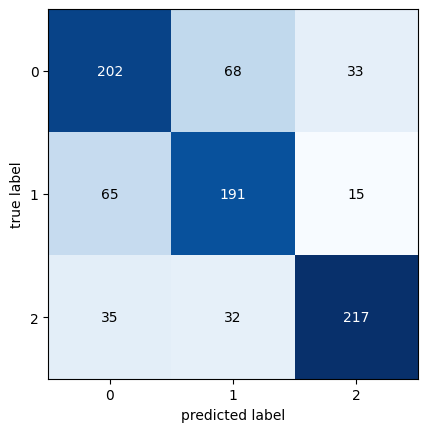

In [37]:
plot_confusion_matrix(confusion_matrix(np.argmax(y_test,axis =1),y_pred))

In [38]:
print(classification_report(np.argmax(y_test, axis=-1), y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       303
           1       0.66      0.70      0.68       271
           2       0.82      0.76      0.79       284

    accuracy                           0.71       858
   macro avg       0.71      0.71      0.71       858
weighted avg       0.71      0.71      0.71       858



# Model Testing

In [39]:
def get_predictions(x):
    # Add all the preprocessing steps here
    x = token.texts_to_sequences([x])
    x = pad_sequences(x,maxlen= 80,padding='post')
    res = np.argmax(model.predict(x),axis=-1)
    
    if res[0] == 0:
        return 'Hate'
    elif res[0] == 1:
        return 'Offensive'
    elif res[0] == 2:
        return 'Neither'
        

In [40]:
x = "You Stupid"

get_predictions(x)

'Hate'

In [41]:
x = "bitch"

get_predictions(x)

'Offensive'

In [42]:
x = "he was talking softly"

get_predictions(x)

'Neither'